In [1]:
#https://www.unaids.org/sites/default/files/country/documents/KAZ_2020_countryreport.pdf
#https://ru.wikipedia.org/wiki/Население_Казахстана
#fertility and death in https://ru.wikipedia.org/wiki/Население_Казахстана
#transition https://www.who.int/news-room/fact-sheets/detail/hiv-aids
#model https://cyberleninka.ru/article/n/hiv-incidence-in-russia-sir-epidemic-model-based-analysis

In [2]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

In [3]:
df = pd.read_excel('HIV_Kazakstan.xlsx')
df

,year,S,I,R,Iisol,total_population per 1000,total
0,2010,16142972.0,11500,51045,900,16204.617,16204617.0
1,2011,16376801.0,12100,54258,1200,16441.959,16441959.0
2,2012,16609663.0,12500,55029,1800,16675.392,16675392.0
3,2013,16847238.0,14200,53273,2800,16911.911,16911911.0
4,2014,17100085.0,15900,52354,3100,17165.239,17165239.0
5,2015,17352725.0,16500,52252,4000,17417.477,17417477.0
6,2016,17604544.0,18500,53013,5100,17670.957,17670957.0
7,2017,17858626.0,20800,54674,8100,17926.000,17926000.0
8,2018,18086834.0,22600,58103,10200,18157.337,18157337.0
9,2019,18349635.0,26000,34032,14100,18395.567,18395567.0


In [4]:
df[0:6]

,year,S,I,R,Iisol,total_population per 1000,total
0,2010,16142972.0,11500,51045,900,16204.617,16204617.0
1,2011,16376801.0,12100,54258,1200,16441.959,16441959.0
2,2012,16609663.0,12500,55029,1800,16675.392,16675392.0
3,2013,16847238.0,14200,53273,2800,16911.911,16911911.0
4,2014,17100085.0,15900,52354,3100,17165.239,17165239.0
5,2015,17352725.0,16500,52252,4000,17417.477,17417477.0


In [5]:
df_train = df[0:6]
df_train

,year,S,I,R,Iisol,total_population per 1000,total
0,2010,16142972.0,11500,51045,900,16204.617,16204617.0
1,2011,16376801.0,12100,54258,1200,16441.959,16441959.0
2,2012,16609663.0,12500,55029,1800,16675.392,16675392.0
3,2013,16847238.0,14200,53273,2800,16911.911,16911911.0
4,2014,17100085.0,15900,52354,3100,17165.239,17165239.0
5,2015,17352725.0,16500,52252,4000,17417.477,17417477.0


In [6]:
df_test = df[6:]
df_test

,year,S,I,R,Iisol,total_population per 1000,total
6,2016,17604544.0,18500,53013,5100,17670.957,17670957.0
7,2017,17858626.0,20800,54674,8100,17926.000,17926000.0
8,2018,18086834.0,22600,58103,10200,18157.337,18157337.0
9,2019,18349635.0,26000,34032,14100,18395.567,18395567.0


In [7]:
time = np.arange(0, 4, 1)
time

array([0, 1, 2, 3])

In [8]:
# # initial guess of model's parameters
# alpha - fertility rate
alpha = 0.02035 #https://ru.wikipedia.org/wiki/Население_Казахстана
#mu - death rate
mu = 0.00709 #https://ru.wikipedia.org/wiki/Население_Казахстана
# fi1 — the probability to give birth a healthy child for an infected mother
fi1 = 0.7 #https://www.who.int/news-room/fact-sheets/detail/hiv-aids
#fi2 - the probability to give birth a healthy child for an infected mother with chemoprophylaxis
fi2 = 0.92 #https://www.who.int/news-room/fact-sheets/detail/hiv-aids
omega = 0.65 # the probability of transition from infected group to a group of isolated ones http://static.government.ru/media/files/cbS7AH8vWirXO6xv7C2mySn1JeqDIvKA.pdf
# beta - transmission rate
beta = 0.13
# gamma transmission rate for HIV
gamma = 0.5

In [9]:
#model

def derivatives(y, t, beta, gamma, omega):
    S, I, Is, R = y
    dSdt = -beta*I*S + ((alpha*(S+fi2*Is+fi1*I) - mu*S) / (S+Is+I))
    dIdt = beta*I*S - gamma*I + ((alpha*(1-fi1)*I-mu*I) / (S+Is+I)) - omega*I
    dIsdt = omega*I - gamma*Is + ((alpha*(1-fi2)*Is - mu*Is) / (
        S+Is+I))
    dRdt = gamma*(I+Is)
    return dSdt, dIdt, dIsdt, dRdt

def loss_function(params, S0, I0, Is0, R0):
    y = S0, I0, Is0, R0
    int = odeint(derivatives, y, time, args=tuple(params))
    y_pred = pd.DataFrame(int, columns=['S', 'I', 'Iisol', 'R'])
    return mean_squared_error(y_true=df_test[['S','I','Iisol','R']], y_pred=y_pred[['S','I', 'Iisol','R']])

In [10]:
# Total population in Kazakstan
S0 = df_train['total'][5]
I0 = df_train['I'][5]  # Total infected
R0 = df_train['R'][5]  # death
Is0 = df_train['Iisol'][5] # Isolated, know status

params = np.array([beta, gamma, omega])

bnds = ((0,0.3), (0,0.08), (0.9, 0.99))

In [11]:
best_params = minimize(fun=loss_function, x0=params, bounds = bnds, method ='Nelder-Mead', tol=1e-10, args=tuple([S0, I0, Is0, R0]))
print(best_params.x)
best_params

C:\Users\gto_n\AppData\Local\Temp\ipykernel_5444\614684842.py:1: OptimizeWarning: Initial guess is not within the specified bounds
  best_params = minimize(fun=loss_function, x0=params, bounds = bnds, method ='Nelder-Mead', tol=1e-10, args=tuple([S0, I0, Is0, R0]))


[0.   0.08 0.9 ]


 final_simplex: (array([[0.00000000e+00, 8.00000000e-02, 9.00000000e-01],
       [0.00000000e+00, 8.00000000e-02, 9.00000000e-01],
       [0.00000000e+00, 8.00000000e-02, 9.00000000e-01],
       [3.75856753e-21, 8.00000000e-02, 9.00000000e-01]]), array([9.67744863e+10, 9.67744863e+10, 9.67744863e+10, 9.67744863e+10]))
           fun: 96774486252.25607
       message: 'Optimization terminated successfully.'
          nfev: 326
           nit: 72
        status: 0
       success: True
             x: array([0.  , 0.08, 0.9 ])

In [12]:
y = S0, I0, Is0, R0
params = tuple(best_params.x)
ret = odeint(derivatives, y, time, args=params)
model_result = pd.DataFrame(ret, columns=['S', 'I','Iisol', 'R'])
model_result.index = df_test.sort_index().index
model_result

,S,I,Iisol,R
6,1.741748e+07,16500.000000,4000.000000,52252.000000
7,1.741748e+07,6192.633051,12731.252047,53828.114899
8,1.741748e+07,2324.163873,15144.783794,55283.052326
9,1.741748e+07,872.284510,15253.586631,56626.128847


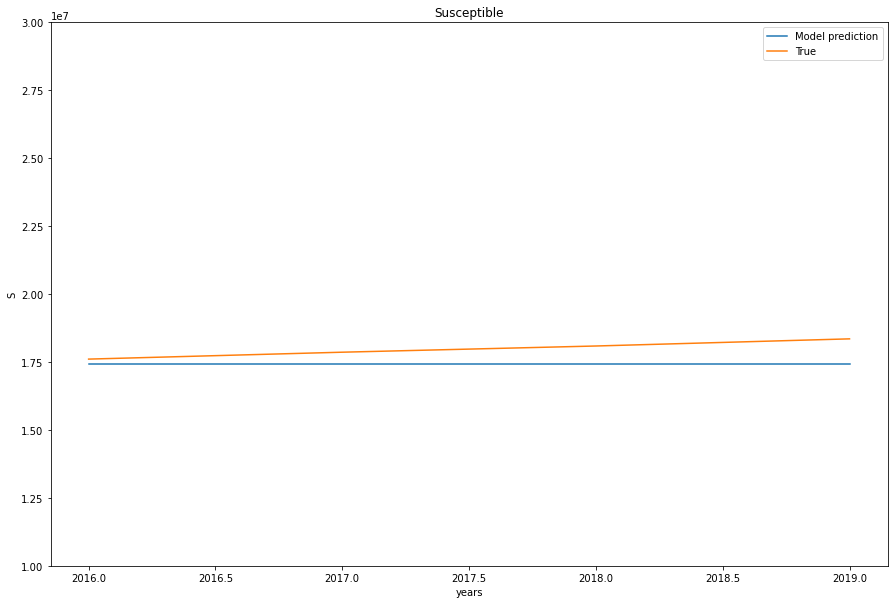

In [13]:
fig = plt.figure(figsize=(15, 10))
plt.plot(df_test['year'], model_result['S'], label='Model prediction')
plt.plot(df_test['year'], df_test['S'], label='True')
plt.legend()
# plt.grid()
plt.xlabel("years")
plt.ylabel('S')
plt.title('Susceptible')
plt.ylim(bottom=1e7)
plt.ylim(top=3e7)
plt.savefig('S.jpg', bbox_inches='tight')
plt.show()

In [218]:
from sklearn.metrics import mean_absolute_error

In [219]:
mean_absolute_error(df_test['S'], model_result['S'])

557432.7301038317

In [226]:
# % error for S
mean_absolute_error(df_test['S'], model_result['S'])/df_test['S'].mean()*100

3.1011712317711733

In [227]:
mean_absolute_error(df_test['I'], model_result['I'])

15502.729641741375

In [229]:
# % error for I
mean_absolute_error(df_test['I'], model_result['I'])/df_test['I'].mean()*100

70.54712009893686

In [230]:
# % error for R
mean_absolute_error(df_test['R'], model_result['R'])/df_test['R'].mean()*100

13.522515850262906

In [231]:
# % error for isolated
mean_absolute_error(df_test['Iisol'], model_result['Iisol'])/df_test['Iisol'].mean()*100

31.54565992310763